# ASSIGNMENT

### Core assignment

Complete the notebook cells that were originally commented **`TODO`**. 

Then, focus on feature engineering to improve your cross validation scores. Collaborate with your cohort on Slack. You could start with the ideas [Jake VanderPlas suggests:](https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic)

> Our model is almost certainly missing some relevant information. For example, nonlinear effects (such as effects of precipitation and cold temperature) and nonlinear trends within each variable (such as disinclination to ride at very cold and very hot temperatures) cannot be accounted for in this model. Additionally, we have thrown away some of the finer-grained information (such as the difference between a rainy morning and a rainy afternoon), and we have ignored correlations between days (such as the possible effect of a rainy Tuesday on Wednesday's numbers, or the effect of an unexpected sunny day after a streak of rainy days). These are all potentially interesting effects, and you now have the tools to begin exploring them if you wish!

At the end of the day, take the last step in the "universal workflow of machine learning" — "You can train your final production model on all the available data (training and validation) and evaluate it one last time on the test set."

See the [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) documentation for the `refit` parameter, `best_estimator_` attribute, and `predict` method:

> **refit : boolean, or string, default=True**

> Refit an estimator using the best found parameters on the whole dataset.

> The refitted estimator is made available at the `best_estimator_` attribute and permits using `predict` directly on this `GridSearchCV` instance.

### More options

**A.** Apply this lesson to other datasets.

**B.** We predicted the number of bicycle trips based on that day's weather. But imagine you were asked to predict trips at the beginning of each day, based only on data known at the time of prediction or before — so you cannot use the current day's weather. How would you wrangle the features to handle this new requirement? How does this impact the predictive accuracy and coefficients of your models?

**C.** In additon to `GridSearchCV`, scikit-learn has [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html), which is sometimes even better. Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.

**D.** _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?




# Imports

In [13]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import skopt
from skopt import BayesSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load Data

In [14]:
counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True, 
                     infer_datetime_format=True)

weather = pd.read_csv('BicycleWeather.csv', index_col='DATE', parse_dates=True, 
                      infer_datetime_format=True)

daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

weather_columns = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND']
daily = daily.join(weather[weather_columns], how='inner')

In [15]:
daily['Total_yesterday'] = daily.Total.shift(1)/1000



In [134]:
daily['Total_yesterday']

2012-10-05    3.475
2012-10-06    3.148
2012-10-07    2.006
2012-10-08    2.142
2012-10-09    3.537
2012-10-10    3.501
2012-10-11    3.235
2012-10-12    3.047
2012-10-13    2.011
2012-10-14    0.766
2012-10-15    0.698
2012-10-16    2.273
2012-10-17    3.036
2012-10-18    3.243
2012-10-19    2.923
2012-10-20    1.977
2012-10-21    1.068
2012-10-22    0.989
2012-10-23    2.129
2012-10-24    2.500
2012-10-25    2.429
2012-10-26    2.713
2012-10-27    2.073
2012-10-28    0.531
2012-10-29    1.062
2012-10-30    2.217
2012-10-31    1.735
2012-11-01    1.710
2012-11-02    2.091
2012-11-03    2.478
              ...  
2015-08-03    1.883
2015-08-04    4.243
2015-08-05    4.655
2015-08-06    4.108
2015-08-07    4.295
2015-08-08    4.100
2015-08-09    2.014
2015-08-10    2.945
2015-08-11    3.898
2015-08-12    4.530
2015-08-13    4.403
2015-08-14    4.428
2015-08-15    2.062
2015-08-16    1.702
2015-08-17    2.333
2015-08-18    4.319
2015-08-19    4.508
2015-08-20    4.548
2015-08-21    3.846


In [16]:
daily.head(1).index.values

array(['2012-10-03T00:00:00.000000000'], dtype='datetime64[ns]')

In [17]:
daily = daily.drop(daily.head(2).index.values)

In [18]:
train = daily[:-100]
test = daily[-100:]

In [19]:
X_train = train.drop(columns='Total')
y_train = train.Total

X_test  = test.drop(columns='Total')
y_test  = test.Total

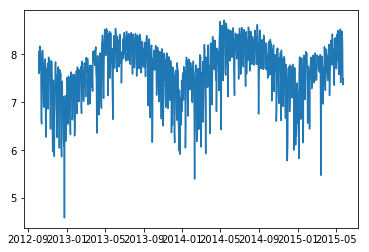

In [20]:
plt.plot(np.log(y_train))

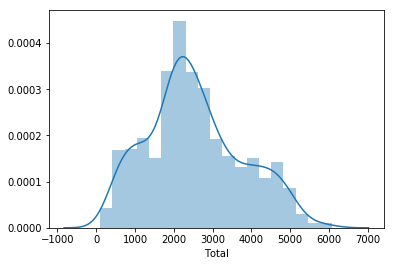

In [21]:
sns.distplot(y_train)

#### Convert total riders to log
No such thing as negative riders

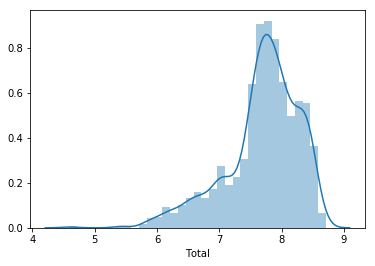

In [22]:
sns.distplot(np.log(y_train))

In [23]:
y_train = np.log(train.Total)
y_test  = np.log(test.Total)

## Baselines

In [24]:
y_pred = np.full(shape=y_train.shape, fill_value=y_train.mean())
mean_absolute_error(y_train, y_pred)

0.4493204116302913

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

scores = cross_validate(LinearRegression(), X_train, y_train, 
                        scoring='neg_mean_absolute_error', cv=3, 
                        return_train_score=True)

pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.001995,0.000997,-0.306282,-0.311022
1,0.000997,0.000000,-0.340336,-0.305948
2,0.000997,0.000000,-0.306924,-0.320464


## Feature engineering from notebook

In [26]:
# Modified from code cells 17-21 at
# https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic


# patterns of use generally vary from day to day; 
# let's add binary columns that indicate the day of the week:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i, day in enumerate(days):
    X_train[day] = (X_train.index.dayofweek == i).astype(float)


    
# we might expect riders to behave differently on holidays; 
# let's add an indicator of this as well:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
X_train = X_train.join(pd.Series(1, index=holidays, name='holiday'))
X_train['holiday'].fillna(0, inplace=True)



# We also might suspect that the hours of daylight would affect 
# how many people ride; let's use the standard astronomical calculation 
# to add this information:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

X_train['daylight_hrs'] = list(map(hours_of_daylight, X_train.index))



# temperatures are in 1/10 deg C; convert to C
X_train['TMIN'] /= 10
X_train['TMAX'] /= 10

# We can also calcuate the average temperature.
X_train['Temp (C)'] = 0.5 * (X_train['TMIN'] + X_train['TMAX'])



# precip is in 1/10 mm; convert to inches
X_train['PRCP'] /= 254

# In addition to the inches of precipitation, let's add a flag that 
# indicates whether a day is dry (has zero precipitation):
X_train['dry day'] = (X_train['PRCP'] == 0).astype(int)



# Let's add a counter that increases from day 1, and measures how many 
# years have passed. This will let us measure any observed annual increase 
# or decrease in daily crossings:
X_train['annual'] = (X_train.index - X_train.index[0]).days / 365.

In [27]:
scores = cross_validate(LinearRegression(), X_train, y_train, 
                        scoring='neg_mean_absolute_error', cv=3, 
                        return_train_score=True)

pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.002991,0.0,-0.167503,-0.153943
1,0.000997,0.0,-0.168569,-0.157332
2,0.001995,0.0,-0.155670,-0.162172


## Random forest todo from lecture

In [28]:
param_grid = {
    'n_estimators': [100], 
    'max_depth': [5, 10, 15], 
    'criterion': ['mae']
}
gridsearch = GridSearchCV(RandomForestRegressor(), param_grid=param_grid,
                         scoring = 'neg_mean_absolute_error',cv=3,
                         return_train_score =True)
gridsearch.fit(X_train, y_train)


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100], 'max_depth': [5, 10, 15], 'criterion': ['mae']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [29]:
pd.DataFrame(gridsearch.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
2,1.765425,0.032895,0.005390,0.000413,mae,15,100,"{'criterion': 'mae', 'max_depth': 15, 'n_estim...",-0.155699,-0.151925,-0.133570,-0.147079,0.009661,1,-0.052551,-0.053009,-0.058146,-0.054568,0.002536
1,1.597935,0.028770,0.005300,0.000462,mae,10,100,"{'criterion': 'mae', 'max_depth': 10, 'n_estim...",-0.155034,-0.154684,-0.136705,-0.148820,0.008555,2,-0.064505,-0.063560,-0.068754,-0.065606,0.002259
0,1.151216,0.034273,0.003658,0.000470,mae,5,100,"{'criterion': 'mae', 'max_depth': 5, 'n_estima...",-0.172960,-0.180761,-0.160655,-0.171470,0.008273,3,-0.135104,-0.126800,-0.140241,-0.134048,0.005538


### Add month

In [30]:
month = ['Jan', 'Feb', 'Mar', 'April', 'May', 'June', 'July','August','Sep', 'Oct', 'Nov','Dec']
for i, month in enumerate(month):
    X_train[month] = (X_train.index.month == i).astype(float)

In [31]:
scores = cross_validate(LinearRegression(), X_train, y_train, 
                        scoring='neg_mean_absolute_error', cv=3, 
                        return_train_score=True)

pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.003963,0.0,-0.164284,-0.142393
1,0.003989,0.0,-0.158010,-0.147045
2,0.000996,0.0,-0.154062,-0.147340


### add season

In [32]:

X_train["Winter"] = X_train["Dec"] + X_train["Jan"] +X_train["Feb"]

X_train["Spring"] = X_train["Mar"] +X_train["April"]+X_train["May"]

X_train["Summer"] = X_train["June"] +X_train["July"]+X_train["August"]

X_train["Fall"] = X_train["Sep"] +X_train["Oct"]+X_train["Nov"]

In [33]:
scores = cross_validate(LinearRegression(), X_train, y_train, 
                        scoring='neg_mean_absolute_error', cv=3, 
                        return_train_score=True)

pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.002991,0.000000,-0.164284,-0.142393
1,0.001995,0.000000,-0.158010,-0.147045
2,0.000997,0.000998,-0.154062,-0.147340


In [34]:
scores = cross_validate(LinearRegression(), X_train.drop(['Jan', 'Feb', 'Mar', 'April', 'May', 'June', \
                                                       'July','August','Sep', 'Oct', 'Nov','Dec'],axis=1 ), y_train, 
                        scoring='neg_mean_absolute_error', cv=3, 
                        return_train_score=True)

pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.001995,0.0,-0.163409,-0.147408
1,0.000997,0.0,-0.162317,-0.150895
2,0.001994,0.0,-0.155777,-0.151815


In [35]:
import statsmodels.api as sm
model = sm.OLS(y_train, sm.add_constant(X_train.drop(['Jan', 'Feb', 'Mar', 'April', 'May', 'June', \
                                                       'July','August','Sep', 'Oct', 'Nov','Dec'],axis=1 )))
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  Total   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     312.6
Date:                Thu, 31 Jan 2019   Prob (F-statistic):               0.00
Time:                        15:32:43   Log-Likelihood:                 129.86
No. Observations:                 962   AIC:                            -215.7
Df Residuals:                     940   BIC:                            -108.6
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               5.8612      0.058    1

In [36]:
X_train["Temp (C)"].mean()

11.750051975051969

In [37]:
X_train["Dist_from_avg_temp"] = abs(X_train["Temp (C)"] - X_train["Temp (C)"].mean())

In [38]:
scores = cross_validate(LinearRegression(), X_train.drop(['Jan', 'Feb', 'Mar', 'April', 'May', 'June',
                                                          'July','August','Sep', 'Oct', 'Nov','Dec'],axis=1 ), y_train, 
                        scoring='neg_mean_absolute_error', cv=3, 
                        return_train_score=True)

pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.000997,0.000998,-0.158293,-0.142032
1,0.000997,0.000000,-0.158673,-0.143737
2,0.001996,0.000000,-0.148601,-0.146309


In [39]:
import statsmodels.api as sm
model = sm.OLS(y_train, sm.add_constant(X_train.drop(['Jan', 'Feb', 'Mar', 'April', 'May', 'June', \
                                                       'July','August','Sep', 'Oct', 'Nov','Dec'],axis=1 )))
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  Total   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     318.1
Date:                Thu, 31 Jan 2019   Prob (F-statistic):               0.00
Time:                        15:32:43   Log-Likelihood:                 157.26
No. Observations:                 962   AIC:                            -268.5
Df Residuals:                     939   BIC:                            -156.5
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  5.9132      0

In [40]:
X_train["Weekday"] = X_train["Mon"] +X_train["Tue"]+X_train["Wed"] + X_train["Thu"]+ X_train["Fri"]

X_train["Weekend"] = X_train["Sat"] +X_train["Sun"]

In [41]:
X_train["ideal_temp"]=X_train["Temp (C)"].apply(lambda x : 1 if ((x>15.) & (x<27.)) else 0)

In [42]:

model = sm.OLS(y_train, sm.add_constant(X_train.drop(['Jan', 'Feb', 'Mar', 'April', 'May', 'June', \
                                                       'July','August','Sep', 'Oct', 'Nov','Dec', "Temp (C)"\
                                                     , "Mon","Tue","Wed","Thu","Fri","Sat","Sun"],axis=1 )))
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  Total   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     347.5
Date:                Thu, 31 Jan 2019   Prob (F-statistic):               0.00
Time:                        15:32:43   Log-Likelihood:                 108.28
No. Observations:                 962   AIC:                            -178.6
Df Residuals:                     943   BIC:                            -86.05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  4.4163      0

In [43]:
scores = cross_validate(LinearRegression(), X_train.drop(['Jan', 'Feb', 'Mar', 'April', 'May', 'June','July','August','Sep', 'Oct', 'Nov','Dec', "Temp (C)"
                                                     , "Mon","Tue","Wed","Thu","Fri","Sat","Sun"],axis=1 ), y_train, 
                        scoring='neg_mean_absolute_error', cv=3, 
                        return_train_score=True)

pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.001995,0.0,-0.162045,-0.146864
1,0.001995,0.0,-0.166252,-0.149431
2,0.001994,0.0,-0.153340,-0.152554


### Drop month and weekday/weekend and temp and Rolling 3

In [44]:
X_train = X_train.drop(['Jan', 'Feb', 'Mar', 'April', 'May', 'June',
                        'July','August','Sep', 'Oct', 'Nov','Dec', "Temp (C)","Weekday","Weekend"],axis=1 )

In [45]:
X_train.describe()

,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday,Mon,Tue,Wed,...,holiday,daylight_hrs,dry day,annual,Winter,Spring,Summer,Fall,Dist_from_avg_temp,ideal_temp
count,962.000000,962.000000,962.000000,962.000000,962.000000,962.000000,962.000000,962.000000,962.000000,962.000000,...,962.000000,962.000000,962.000000,962.000000,962.000000,962.000000,962.000000,962.000000,962.000000,962.000000
mean,0.123705,-41.433472,0.109148,15.669854,7.830249,31.854470,2.535117,0.142412,0.142412,0.142412,...,0.028067,11.677857,0.554054,1.316438,0.190229,0.277547,0.216216,0.219335,4.745172,0.290021
std,0.264718,643.768975,2.701512,6.997671,4.916549,14.612356,1.224457,0.349654,0.349654,0.349654,...,0.165249,2.570035,0.497328,0.761232,0.392686,0.448021,0.411878,0.414011,3.259626,0.454008
min,0.000000,-9999.000000,0.000000,-1.600000,-7.100000,4.000000,0.098000,0.000000,0.000000,0.000000,...,0.000000,8.218894,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050052,0.000000
25%,0.000000,0.000000,0.000000,10.600000,4.400000,22.000000,1.753500,0.000000,0.000000,0.000000,...,0.000000,9.204093,0.000000,0.658219,0.000000,0.000000,0.000000,0.000000,2.149948,0.000000
50%,0.000000,0.000000,0.000000,14.400000,7.800000,29.000000,2.381000,0.000000,0.000000,0.000000,...,0.000000,11.372182,1.000000,1.316438,0.000000,0.000000,0.000000,0.000000,4.250052,0.000000
75%,0.129921,0.000000,0.000000,20.600000,11.700000,40.750000,3.319750,0.000000,0.000000,0.000000,...,0.000000,14.122158,1.000000,1.974658,0.000000,1.000000,0.000000,0.000000,6.849948,1.000000
max,2.200787,74.000000,80.000000,35.600000,18.300000,95.000000,6.088000,1.000000,1.000000,1.000000,...,1.000000,15.781095,1.000000,2.632877,1.000000,1.000000,1.000000,1.000000,15.550052,1.000000


In [46]:
X_train.columns.values

array(['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND', 'Total_yesterday',
       'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
       'daylight_hrs', 'dry day', 'annual', 'Winter', 'Spring', 'Summer',
       'Fall', 'Dist_from_avg_temp', 'ideal_temp'], dtype=object)

In [79]:
X_train = X_train.replace(-9999,0)
X_train.describe()

,PRCP,SNOW,SNWD,Total_yesterday,Mon,Tue,Wed,Thu,Fri,Sat,...,daylight_hrs,dry day,annual,Winter,Spring,Summer,Fall,Dist_from_avg_temp,ideal_temp,log_AWND
count,962.000000,962.000000,962.000000,962.000000,962.000000,962.000000,962.000000,962.000000,962.000000,962.000000,...,962.000000,962.000000,962.000000,962.000000,962.000000,962.000000,962.000000,962.000000,962.000000,962.000000
mean,0.123705,0.142412,0.109148,2.535117,0.142412,0.142412,0.142412,0.142412,0.143451,0.143451,...,11.677857,0.554054,1.316438,0.190229,0.277547,0.216216,0.219335,4.745172,0.290021,3.351775
std,0.264718,2.672847,2.701512,1.224457,0.349654,0.349654,0.349654,0.349654,0.350715,0.350715,...,2.570035,0.497328,0.761232,0.392686,0.448021,0.411878,0.414011,3.259626,0.454008,0.486011
min,0.000000,0.000000,0.000000,0.098000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,8.218894,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050052,0.000000,1.386294
25%,0.000000,0.000000,0.000000,1.753500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.204093,0.000000,0.658219,0.000000,0.000000,0.000000,0.000000,2.149948,0.000000,3.091042
50%,0.000000,0.000000,0.000000,2.381000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,11.372182,1.000000,1.316438,0.000000,0.000000,0.000000,0.000000,4.250052,0.000000,3.367296
75%,0.129921,0.000000,0.000000,3.319750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,14.122158,1.000000,1.974658,0.000000,1.000000,0.000000,0.000000,6.849948,1.000000,3.707399
max,2.200787,74.000000,80.000000,6.088000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,15.781095,1.000000,2.632877,1.000000,1.000000,1.000000,1.000000,15.550052,1.000000,4.553877


In [80]:
model = sm.OLS(y_train, sm.add_constant(X_train))
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  Total   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     294.2
Date:                Thu, 31 Jan 2019   Prob (F-statistic):               0.00
Time:                        15:46:36   Log-Likelihood:                 104.40
No. Observations:                 962   AIC:                            -164.8
Df Residuals:                     940   BIC:                            -57.67
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  5.9459      0

In [81]:
scores = cross_validate(LinearRegression(), X_train, y_train, 
                        scoring='neg_mean_absolute_error', cv=3, 
                        return_train_score=True)

pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.001995,0.0,-0.167599,-0.153314
1,0.001994,0.0,-0.175987,-0.157828
2,0.001995,0.0,-0.159034,-0.157292


In [82]:
model = sm.OLS(y_train, sm.add_constant(X_train.drop(["TMAX","TMIN"],axis=1)))
print(model.fit().summary())

KeyError: "labels ['TMAX' 'TMIN'] not contained in axis"

## Drop TMIN, TMAX

In [83]:
X_train=X_train.drop(["TMIN","TMAX"],axis=1)

KeyError: "labels ['TMIN' 'TMAX'] not contained in axis"

In [84]:
sns.distplot(np.log(X_train["AWND"]))

KeyError: 'AWND'

In [85]:
X_train["log_AWND"] = np.log(X_train["AWND"])

KeyError: 'AWND'

In [86]:
X_train["ideal_AWND"] = X_train["log_AWND"].apply(lambda x: 1 if x<3.1 else 0)

In [87]:
X_train["log_AWND"]

2012-10-05    4.043051
2012-10-06    3.931826
2012-10-07    2.564949
2012-10-08    2.944439
2012-10-09    2.772589
2012-10-10    2.639057
2012-10-11    2.564949
2012-10-12    3.828641
2012-10-13    3.663562
2012-10-14    3.526361
2012-10-15    3.828641
2012-10-16    4.007333
2012-10-17    2.772589
2012-10-18    2.995732
2012-10-19    3.970292
2012-10-20    4.043051
2012-10-21    3.295837
2012-10-22    3.258097
2012-10-23    3.401197
2012-10-24    3.044522
2012-10-25    2.708050
2012-10-26    3.218876
2012-10-27    3.931826
2012-10-28    3.637586
2012-10-29    3.891820
2012-10-30    3.332205
2012-10-31    3.295837
2012-11-01    3.401197
2012-11-02    2.302585
2012-11-03    3.583519
                ...   
2015-04-25    3.401197
2015-04-26    3.295837
2015-04-27    3.135494
2015-04-28    3.761200
2015-04-29    3.850148
2015-04-30    3.044522
2015-05-01    3.610918
2015-05-02    3.610918
2015-05-03    3.258097
2015-05-04    3.951244
2015-05-05    3.931826
2015-05-06    3.258097
2015-05-07 

In [88]:
X_train["ideal_AWND"]

2012-10-05    0
2012-10-06    0
2012-10-07    1
2012-10-08    1
2012-10-09    1
2012-10-10    1
2012-10-11    1
2012-10-12    0
2012-10-13    0
2012-10-14    0
2012-10-15    0
2012-10-16    0
2012-10-17    1
2012-10-18    1
2012-10-19    0
2012-10-20    0
2012-10-21    0
2012-10-22    0
2012-10-23    0
2012-10-24    1
2012-10-25    1
2012-10-26    0
2012-10-27    0
2012-10-28    0
2012-10-29    0
2012-10-30    0
2012-10-31    0
2012-11-01    0
2012-11-02    1
2012-11-03    0
             ..
2015-04-25    0
2015-04-26    0
2015-04-27    0
2015-04-28    0
2015-04-29    0
2015-04-30    1
2015-05-01    0
2015-05-02    0
2015-05-03    0
2015-05-04    0
2015-05-05    0
2015-05-06    0
2015-05-07    0
2015-05-08    0
2015-05-09    0
2015-05-10    0
2015-05-11    0
2015-05-12    0
2015-05-13    0
2015-05-14    1
2015-05-15    0
2015-05-16    0
2015-05-17    1
2015-05-18    0
2015-05-19    0
2015-05-20    1
2015-05-21    1
2015-05-22    0
2015-05-23    0
2015-05-24    0
Name: ideal_AWND, Length

In [89]:
X_train["ideal_AWND"] *  X_train["ideal_temp"]

2012-10-05    0
2012-10-06    0
2012-10-07    1
2012-10-08    0
2012-10-09    0
2012-10-10    0
2012-10-11    0
2012-10-12    0
2012-10-13    0
2012-10-14    0
2012-10-15    0
2012-10-16    0
2012-10-17    0
2012-10-18    0
2012-10-19    0
2012-10-20    0
2012-10-21    0
2012-10-22    0
2012-10-23    0
2012-10-24    0
2012-10-25    0
2012-10-26    0
2012-10-27    0
2012-10-28    0
2012-10-29    0
2012-10-30    0
2012-10-31    0
2012-11-01    0
2012-11-02    0
2012-11-03    0
             ..
2015-04-25    0
2015-04-26    0
2015-04-27    0
2015-04-28    0
2015-04-29    0
2015-04-30    0
2015-05-01    0
2015-05-02    0
2015-05-03    0
2015-05-04    0
2015-05-05    0
2015-05-06    0
2015-05-07    0
2015-05-08    0
2015-05-09    0
2015-05-10    0
2015-05-11    0
2015-05-12    0
2015-05-13    0
2015-05-14    0
2015-05-15    0
2015-05-16    0
2015-05-17    0
2015-05-18    0
2015-05-19    0
2015-05-20    1
2015-05-21    1
2015-05-22    0
2015-05-23    0
2015-05-24    0
Length: 962, dtype: int6

In [90]:
X_train["ideal_weather"] = (X_train["ideal_AWND"] *  X_train["ideal_temp"])

In [118]:
scores = cross_validate(LinearRegression(), X_train, y_train, 
                        scoring='neg_mean_absolute_error', cv=3, 
                        return_train_score=True)

pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.001994,0.000000,-0.166682,-0.152854
1,0.001995,0.000000,-0.175432,-0.157534
2,0.001995,0.000997,-0.159408,-0.157017


In [120]:
model = sm.OLS(y_train, sm.add_constant(X_train))
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  Total   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     268.8
Date:                Thu, 31 Jan 2019   Prob (F-statistic):               0.00
Time:                        15:57:45   Log-Likelihood:                 105.56
No. Observations:                 962   AIC:                            -163.1
Df Residuals:                     938   BIC:                            -46.27
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  6.0491      0

In [122]:
X_train = X_train.drop(["ideal_AWND","ideal_weather"],axis=1)

In [131]:
X_train["Total_yesterday"] = np.sqrt(X_train["Total_yesterday"])

In [149]:
X_train["daylight_hrs"] = X_train["daylight_hrs"]**0.5 +4

In [150]:
scores = cross_validate(LinearRegression(), X_train, y_train, 
                        scoring='neg_mean_absolute_error', cv=3, 
                        return_train_score=True)

pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.001995,0.0,-0.165075,-0.149349
1,0.001996,0.0,-0.168171,-0.154011
2,0.001995,0.0,-0.153608,-0.154649


In [151]:
model = sm.OLS(y_train, sm.add_constant(X_train))
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  Total   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     312.3
Date:                Thu, 31 Jan 2019   Prob (F-statistic):               0.00
Time:                        16:15:44   Log-Likelihood:                 129.43
No. Observations:                 962   AIC:                            -214.9
Df Residuals:                     940   BIC:                            -107.7
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  4.3902      0

In [125]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [126]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'polynomialfeatures__degree': [0, 1, 2, 3]
}

gridsearch = GridSearchCV(PolynomialRegression(), param_grid=param_grid, 
                          scoring='neg_mean_absolute_error', cv=3, 
                          return_train_score=True, verbose=10)

gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] polynomialfeatures__degree=0 ....................................
[CV]  polynomialfeatures__degree=0, score=-0.46893958654754186, total=   0.0s
[CV] polynomialfeatures__degree=0 ....................................
[CV]  polynomialfeatures__degree=0, score=-0.460106064855922, total=   0.0s
[CV] polynomialfeatures__degree=0 ....................................
[CV]  polynomialfeatures__degree=0, score=-0.42821697251061003, total=   0.0s
[CV] polynomialfeatures__degree=1 ....................................
[CV]  polynomialfeatures__degree=1, score=-0.1675986660531134, total=   0.0s
[CV] polynomialfeatures__degree=1 ....................................
[CV]  polynomialfeatures__degree=1, score=-0.17598673536589202, total=   0.0s
[CV] polynomialfeatures__degree=1 ....................................
[CV]  polynomialfeatures__degree=1, score=-0.15903374822251204, total=   0.0s
[CV] polynomialfeatures__degree=2 ...............

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s


[CV]  polynomialfeatures__degree=3, score=-4.763587777732645, total=   0.0s
[CV] polynomialfeatures__degree=3 ....................................
[CV]  polynomialfeatures__degree=3, score=-3.704895494380017, total=   0.0s
[CV] polynomialfeatures__degree=3 ....................................
[CV]  polynomialfeatures__degree=3, score=-5.490130478354539, total=   0.0s


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.5s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'polynomialfeatures__degree': [0, 1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=10)

In [127]:
for degree in [0, 1, 2, 3]:
    features = PolynomialFeatures(degree).fit(X_train).get_feature_names(X_train.columns)
    print(f'{degree} degree polynomial has {len(features)} features')
    print(features)
    print('\n')

0 degree polynomial has 1 features
['1']


1 degree polynomial has 23 features
['1', 'PRCP', 'SNOW', 'SNWD', 'Total_yesterday', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday', 'daylight_hrs', 'dry day', 'annual', 'Winter', 'Spring', 'Summer', 'Fall', 'Dist_from_avg_temp', 'ideal_temp', 'log_AWND']


2 degree polynomial has 276 features
['1', 'PRCP', 'SNOW', 'SNWD', 'Total_yesterday', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday', 'daylight_hrs', 'dry day', 'annual', 'Winter', 'Spring', 'Summer', 'Fall', 'Dist_from_avg_temp', 'ideal_temp', 'log_AWND', 'PRCP^2', 'PRCP SNOW', 'PRCP SNWD', 'PRCP Total_yesterday', 'PRCP Mon', 'PRCP Tue', 'PRCP Wed', 'PRCP Thu', 'PRCP Fri', 'PRCP Sat', 'PRCP Sun', 'PRCP holiday', 'PRCP daylight_hrs', 'PRCP dry day', 'PRCP annual', 'PRCP Winter', 'PRCP Spring', 'PRCP Summer', 'PRCP Fall', 'PRCP Dist_from_avg_temp', 'PRCP ideal_temp', 'PRCP log_AWND', 'SNOW^2', 'SNOW SNWD', 'SNOW Total_yesterday', 'SNOW Mon', 'SNOW Tue', 'SNOW Wed', 'S

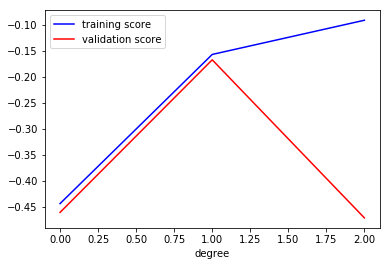

In [128]:
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

degree = [0, 1, 2]
train_score, val_score = validation_curve(
    PolynomialRegression(), X_train, y_train,
    param_name='polynomialfeatures__degree', param_range=degree, 
    scoring='neg_mean_absolute_error', cv=3)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.xlabel('degree');

In [100]:
param_grid = {
    'n_estimators': [100], 
    'max_depth': [5, 10, 15], 
    'criterion': ['mae']
}
gridsearch = GridSearchCV(RandomForestRegressor(), param_grid=param_grid,
                         scoring = 'neg_mean_absolute_error',cv=3,
                         return_train_score =True)
gridsearch.fit(X_train, y_train)
results = pd.DataFrame(gridsearch.cv_results_)
print(f'Best result from grid search of {len(results)} parameter combinations')
results.sort_values(by='rank_test_score').head(1)

KeyboardInterrupt: 

In [ ]:
pca = PCA(10)

In [ ]:
x = X_train[["PRCP","SNOW","SNWD","Total_yesterday","daylight_hrs","annual","Dist_from_avg_temp","log_AWND"]]
x = StandardScaler().fit_transform(x)

In [ ]:
y = X_train.drop(["PRCP","SNOW","SNWD","Total_yesterday","daylight_hrs","annual","Dist_from_avg_temp","log_AWND"],axis=1)
y

In [ ]:
pca_x = pca.fit_transform(X_train)

In [ ]:
pca_x=pd.DataFrame(pca_x)
pca_x

In [ ]:
scores = cross_validate(LinearRegression(), pca_x, y_train, 
                        scoring='neg_mean_absolute_error', cv=3, 
                        return_train_score=True)

pd.DataFrame(scores)

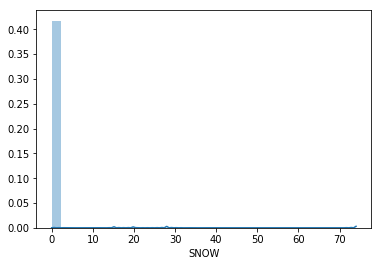

In [129]:
sns.distplot((X_train["SNOW"]))

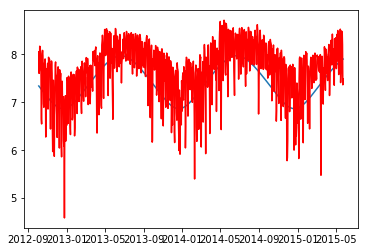

In [148]:
plt.plot(X_train["daylight_hrs"]**0.5 +4)
plt.plot(y_train, color='r')

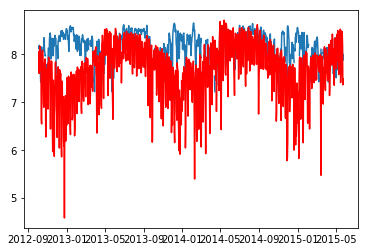

In [167]:
plt.plot((np.log(X_train["Dist_from_avg_temp"]))**0.5+7)
plt.plot(y_train, color='r')

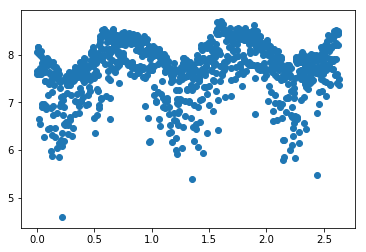

In [168]:
plt.scatter(X_train["annual"],y_train)

In [75]:
# pairplot_Data= pd.concat([X_train,y_train],axis=1)
# pairplot_Data.head()
# sns.pairplot(data = pairplot_Data, x_vars = X_train.columns.values, y_vars=pairplot_Data["Total"])


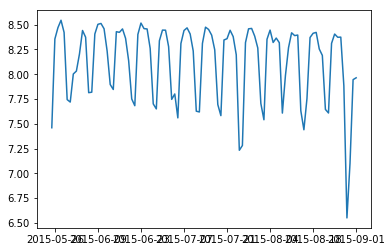

In [169]:
plt.plot(y_test)